Basic MLP with MNIST data
===========

Import pakages
-----

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

Download datas
-----

In [2]:
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)

In [3]:
print(mnist.data[0])
print(type(mnist.data[0]))

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.  18.
  18.  18. 126. 136. 175.  26. 166. 255. 247. 127.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.  30.  36.  94. 154. 170. 253.
 253. 253. 253. 253. 225. 172. 253. 242. 195.  64.   0.   0.   0.   0.
   0. 

In [4]:
print(mnist.target[0])
print(type(mnist.target[0]))

5
<class 'str'>


Preprocess datas
----

In [5]:
mnist.target = mnist.target.astype(np.int8) # Target이 지금 'str'형으로 되어 있는데 이를 'int'형으로 바꿈


In [6]:
X = mnist.data / 255  # 0-255값을 [0,1] 구간으로 정규화
y = mnist.target

이 이미지 데이터의 레이블은 5이다


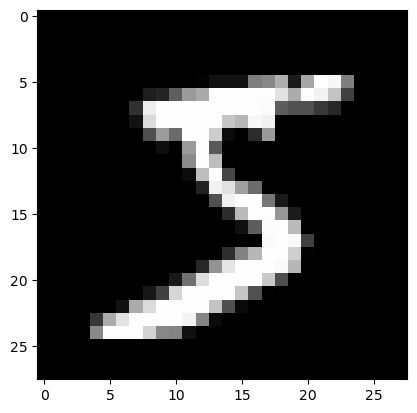

In [7]:
plt.imshow(X[0].reshape(28, 28), cmap='gray')
print("이 이미지 데이터의 레이블은 {:.0f}이다".format(y[0]))

In [8]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from torch import nn
from torchsummary import summary as summary_


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7, random_state=0)

X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

ds_train = TensorDataset(X_train, y_train)
ds_test = TensorDataset(X_test, y_test)

loader_train = DataLoader(ds_train, batch_size=64, shuffle=True)
loader_test = DataLoader(ds_test, batch_size=64, shuffle=False)

In [35]:
model = nn.Sequential()
model.add_module('fc1', nn.Linear(28*28*1, 512))
model.add_module('relu1', nn.ReLU())
model.add_module('fc2', nn.Linear(512, 256))
model.add_module('relu2', nn.ReLU())
model.add_module('fc3', nn.Linear(256, 256))
model.add_module('relu3', nn.ReLU())
model.add_module('fc4', nn.Linear(256, 128))
model.add_module('relu4', nn.ReLU())
model.add_module('fc5', nn.Linear(128, 128))
model.add_module('relu5', nn.ReLU())
model.add_module('fc6', nn.Linear(128, 64))
model.add_module('relu6', nn.ReLU())
model.add_module('fc7', nn.Linear(64, 10))

summary_(model,input_size=(28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
              ReLU-2                  [-1, 512]               0
            Linear-3                  [-1, 256]         131,328
              ReLU-4                  [-1, 256]               0
            Linear-5                  [-1, 256]          65,792
              ReLU-6                  [-1, 256]               0
            Linear-7                  [-1, 128]          32,896
              ReLU-8                  [-1, 128]               0
            Linear-9                  [-1, 128]          16,512
             ReLU-10                  [-1, 128]               0
           Linear-11                   [-1, 64]           8,256
             ReLU-12                   [-1, 64]               0
           Linear-13                   [-1, 10]             650
Total params: 657,354
Trainable params:

In [36]:
from torch import optim

# 오차함수 선택
loss_fn = nn.CrossEntropyLoss()

# 가중치를 학습하기 위한 최적화 기법 선택
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [37]:
def train(epoch):
    model.train()  # 신경망을 학습 모드로 전환
    
    correct = 0

    # 데이터로더에서 미니배치를 하나씩 꺼내 학습을 수행
    for data, targets in loader_train:

        optimizer.zero_grad()  # 경사를 0으로 초기화
        outputs = model(data)  # 데이터를 입력하고 출력을 계산
        loss = loss_fn(outputs, targets)  # 출력과 훈련 데이터 정답 간의 오차를 계산
        loss.backward()  # 오차를 역전파 계산
        optimizer.step()  # 역전파 계산한 값으로 가중치를 수정
        
        with torch.no_grad():
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            correct += predicted.eq(targets.data.view_as(predicted)).sum()
            
    data_num = len(loader_train.dataset)  # 데이터 총 건수
    print('\n학습 데이터에서 예측 정확도: {}/{} ({:.2f}%)\n'.format(correct,
                                                   data_num, 100. * float(correct) / float(data_num)))

    print("epoch{}：완료\n".format(epoch))

In [38]:
def test():
    model.eval()  # 신경망을 추론 모드로 전환
    correct = 0

    # 데이터로더에서 미니배치를 하나씩 꺼내 추론을 수행
    with torch.no_grad():  # 추론 과정에는 미분이 필요없음
        for data, targets in loader_test:

            outputs = model(data)  # 데이터를 입력하고 출력을 계산

            # 추론 계산
            _, predicted = torch.max(outputs.data, 1)  # 확률이 가장 높은 레이블이 무엇인지 계산
            correct += predicted.eq(targets.data.view_as(predicted)).sum()  # 정답과 일치한 경우 정답 카운트를 증가

    # 정확도 출력
    data_num = len(loader_test.dataset)  # 데이터 총 건수
    print('\n테스트 데이터에서 예측 정확도: {}/{} ({:.2f}%)\n'.format(correct,
                                                   data_num, 100. * float(correct) / float(data_num)))
    return float(correct) / float(data_num)

In [39]:
test()



테스트 데이터에서 예측 정확도: 963/10000 (9.63%)



0.0963

In [40]:
acc = []
MAX_ITERATION=20
for epoch in range(MAX_ITERATION):
    train(epoch+1)
    acc.append(test())
    print('====================')



학습 데이터에서 예측 정확도: 54190/60000 (90.32%)

epoch1：완료


테스트 데이터에서 예측 정확도: 9562/10000 (95.62%)


학습 데이터에서 예측 정확도: 58594/60000 (97.66%)

epoch2：완료


테스트 데이터에서 예측 정확도: 9694/10000 (96.94%)


학습 데이터에서 예측 정확도: 59131/60000 (98.55%)

epoch3：완료


테스트 데이터에서 예측 정확도: 9694/10000 (96.94%)


학습 데이터에서 예측 정확도: 59370/60000 (98.95%)

epoch4：완료


테스트 데이터에서 예측 정확도: 9707/10000 (97.07%)


학습 데이터에서 예측 정확도: 59506/60000 (99.18%)

epoch5：완료


테스트 데이터에서 예측 정확도: 9738/10000 (97.38%)


학습 데이터에서 예측 정확도: 59637/60000 (99.39%)

epoch6：완료


테스트 데이터에서 예측 정확도: 9748/10000 (97.48%)


학습 데이터에서 예측 정확도: 59715/60000 (99.53%)

epoch7：완료


테스트 데이터에서 예측 정확도: 9768/10000 (97.68%)


학습 데이터에서 예측 정확도: 59764/60000 (99.61%)

epoch8：완료


테스트 데이터에서 예측 정확도: 9764/10000 (97.64%)


학습 데이터에서 예측 정확도: 59760/60000 (99.60%)

epoch9：완료


테스트 데이터에서 예측 정확도: 9780/10000 (97.80%)


학습 데이터에서 예측 정확도: 59804/60000 (99.67%)

epoch10：완료


테스트 데이터에서 예측 정확도: 9768/10000 (97.68%)


학습 데이터에서 예측 정확도: 59847/60000 (99.75%)

epoch11：완료


테스트 데이터에서 예측 정확도: 9774/10000 (97.74%

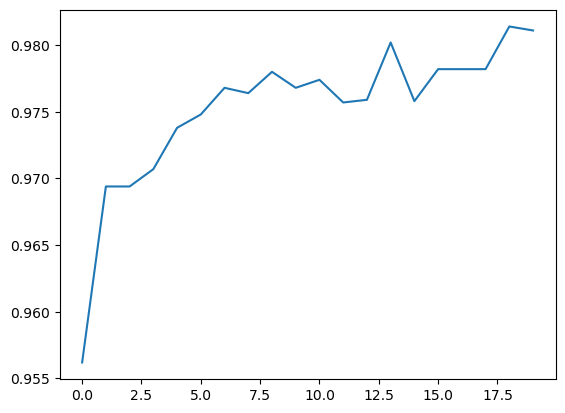

In [41]:
plt.plot(acc)

In [42]:
from PIL import Image
model.eval()

img = Image.open('4-1.jpeg').convert("L")
img = np.array(img)
img = img / 255.0
img = 1 - img
print(img)

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.    

예측 결과 : 5


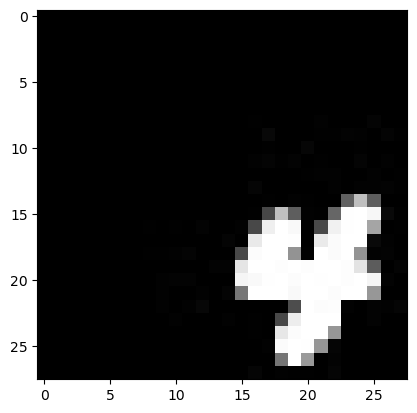

In [43]:
img = img.flatten()


data = torch.tensor(img, dtype=torch.float32)
output = model(data)  # 데이터를 입력하고 출력을 계산
_, predicted = torch.max(output.data, 0)  # 확률이 가장 높은 레이블이 무엇인지 계산
print("예측 결과 : {}".format(predicted))

plt.imshow(img.reshape(28, 28), cmap='gray')

Model with Regularization
=====
Pytorch gives L2 regularization basically by weight_decay in optimization.


In [17]:
model_r = nn.Sequential()
model_r.add_module('fc1', nn.Linear(28*28*1, 512))
model_r.add_module('relu1', nn.ReLU())
model_r.add_module('fc2', nn.Linear(512, 256))
model_r.add_module('relu2', nn.ReLU())
model_r.add_module('fc3', nn.Linear(256, 256))
model_r.add_module('relu3', nn.ReLU())
model_r.add_module('fc4', nn.Linear(256, 128))
model_r.add_module('relu4', nn.ReLU())
model_r.add_module('fc5', nn.Linear(128, 128))
model_r.add_module('relu5', nn.ReLU())
model_r.add_module('fc6', nn.Linear(128, 64))
model_r.add_module('relu6', nn.ReLU())
model_r.add_module('fc7', nn.Linear(64, 10))

summary_(model_r,input_size=(28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
              ReLU-2                  [-1, 512]               0
            Linear-3                  [-1, 256]         131,328
              ReLU-4                  [-1, 256]               0
            Linear-5                  [-1, 256]          65,792
              ReLU-6                  [-1, 256]               0
            Linear-7                  [-1, 128]          32,896
              ReLU-8                  [-1, 128]               0
            Linear-9                  [-1, 128]          16,512
             ReLU-10                  [-1, 128]               0
           Linear-11                   [-1, 64]           8,256
             ReLU-12                   [-1, 64]               0
           Linear-13                   [-1, 10]             650
Total params: 657,354
Trainable params:

In [18]:
# 오차함수 선택
loss_fn_r = nn.CrossEntropyLoss()

# 가중치를 학습하기 위한 최적화 기법 선택
optimizer_r = optim.Adam(model_r.parameters(), lr=0.01,weight_decay=0.0001)

In [19]:
def train_r(epoch):
    model_r.train()  # 신경망을 학습 모드로 전환

    # 데이터로더에서 미니배치를 하나씩 꺼내 학습을 수행
    for data, targets in loader_train:

        optimizer_r.zero_grad()  # 경사를 0으로 초기화
        outputs = model_r(data)  # 데이터를 입력하고 출력을 계산
        loss3 = loss_fn_r(outputs, targets)  # 출력과 훈련 데이터 정답 간의 오차를 계산
        loss3.backward()  # 오차를 역전파 계산
        optimizer_r.step()  # 역전파 계산한 값으로 가중치를 수정

    print("epoch{}：완료\n".format(epoch))

In [20]:
def test_r():
    model_r.eval()  # 신경망을 추론 모드로 전환
    correct = 0

    # 데이터로더에서 미니배치를 하나씩 꺼내 추론을 수행
    with torch.no_grad():  # 추론 과정에는 미분이 필요없음
        for data, targets in loader_test:

            outputs = model_r(data)  # 데이터를 입력하고 출력을 계산

            # 추론 계산
            _, predicted = torch.max(outputs.data, 1)  # 확률이 가장 높은 레이블이 무엇인지 계산
            correct += predicted.eq(targets.data.view_as(predicted)).sum()  # 정답과 일치한 경우 정답 카운트를 증가

    # 정확도 출력
    data_num = len(loader_test.dataset)  # 데이터 총 건수
    print('\n테스트 데이터에서 예측 정확도: {}/{} ({:.2f}%)\n'.format(correct,
                                                   data_num, 100. * correct / data_num))
    
    return float(correct) / float(data_num)

In [21]:
test_r()


테스트 데이터에서 예측 정확도: 963/10000 (9.63%)



0.0963

epoch0：완료


테스트 데이터에서 예측 정확도: 9342/10000 (93.42%)

epoch1：완료


테스트 데이터에서 예측 정확도: 9263/10000 (92.63%)

epoch2：완료


테스트 데이터에서 예측 정확도: 9420/10000 (94.20%)

epoch3：완료


테스트 데이터에서 예측 정확도: 9518/10000 (95.18%)

epoch4：완료


테스트 데이터에서 예측 정확도: 9526/10000 (95.26%)

epoch5：완료


테스트 데이터에서 예측 정확도: 9547/10000 (95.47%)

epoch6：완료


테스트 데이터에서 예측 정확도: 9533/10000 (95.33%)

epoch7：완료


테스트 데이터에서 예측 정확도: 9396/10000 (93.96%)

epoch8：완료


테스트 데이터에서 예측 정확도: 9492/10000 (94.92%)

epoch9：완료


테스트 데이터에서 예측 정확도: 9599/10000 (95.99%)



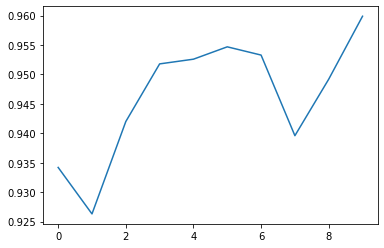

In [22]:
acc_r = []

for epoch in range(MAX_ITERATION):
    train_r(epoch)
    acc_r.append(test_r())

plt.plot(acc_r)

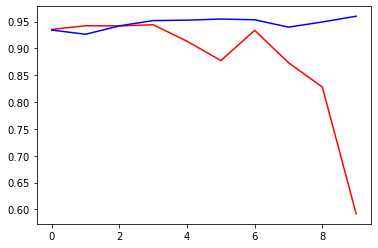

In [23]:
T = np.arange(MAX_ITERATION)
plt.plot(T, acc, 'r', T, acc_r, 'b')